This notebook is about computing how much exploration was done in latent spaces during each BayesOpt run

In [1]:
import torch
import numpy as np
import pandas as pd
import pygmo

import matplotlib.pyplot as plt
import seaborn as sns

from transvae.snc import SNC 

from transvae import trans_models
from transvae.transformer_models import TransVAE
from transvae.tvae_util import *
from transvae.analysis import make_model_name, get_boloop_runs, get_latent_spaces, get_top_2_most_correlated_PCs


import os
import pickle as pkl

In [2]:
from pygmo import hypervolume
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

In [3]:
SAVE_FIGURES=False
ALREADY_SAVED = True # hypervolume computations

# Compute the variance in scores found

In [4]:
make_model_name("bch", "100", "25")

'transvae-64-peptides-bch-zScoreNormalized-25-organized-cdhit90-zScoreNormalized'

In [5]:
results_id  = {}
results_pca = {}

In [6]:
prop="h"
dim_reduction_method="identity" # options: ['identity', 'PCA']
box_bounds=10 # options: [5,10]
end_point = 500

properties = ['b','c','h','bc','bch']#, "predicted-log10mic"]
# properties = ["predicted-log10mic"]

if "predicted-log10mic" in properties:
    percentages = [0,98]
else:
    percentages = [0,25,50,75,98]

for dim_reduction_method in ["identity","PCA"]:
    for _perc in percentages:
        for prop in properties:
            _model_name = make_model_name(prop, "100", _perc)
            
            prop_perc = f"{dim_reduction_method}-{prop}-{_perc}"

            if dim_reduction_method=="identity":
                results_id[prop_perc] = {}            
            else:
                results_pca[prop_perc] = {}
            print(prop_perc)
            
            runs = get_boloop_runs(_model_name, _perc, dim_reduction_method, box_bounds)
            
            _scores = []
            _variances = []
            _top_score = []
            for _run in runs:
                _run_len = len(_run['candidate_scores'])
                _last_point = min(_run_len, end_point)
                if _last_point<200:
                    print(_model_name," with last point: ",_last_point)
                _candidate_scores = np.array(_run['candidate_scores'][:_last_point])
                _candidate_scores = _candidate_scores[np.abs(_candidate_scores)<3.4]
                if len(_candidate_scores)<100:
                    print("encountered run with few non-3.5 values")
                
                _scores.append( _run['candidate_scores'][:_last_point] )
                _variances.append( np.var(_candidate_scores) )
                _top_score.append( _run['best_objective_values'][_last_point-1] )

            if dim_reduction_method=="identity":
                results_id[prop_perc]["variances"] = _variances
                results_id[prop_perc]["best_objective_value"] = _top_score
            else:
                results_pca[prop_perc]["variances"] = _variances
                results_pca[prop_perc]["best_objective_value"] = _top_score
    

identity-b-0
in first if
_fname='boloop_results_identity_neg10to10_transvae-64-peptides-boman-zScoreNormalized-organized-cdhit90-zScoreNormalized_log10_mic.pkl'
identity-c-0
in first if
_fname='boloop_results_identity_neg10to10_transvae-64-peptides-chargepH7p2-zScoreNormalized-organized-cdhit90-zScoreNormalized_log10_mic.pkl'
identity-h-0
in first if
_fname='boloop_results_identity_neg10to10_transvae-64-peptides-hydrophobicity-zScoreNormalized-organized-cdhit90-zScoreNormalized_log10_mic.pkl'
identity-bc-0
in first if
_fname='boloop_results_identity_neg10to10_transvae-64-peptides-boman-chargepH7p2-zScoreNormalized-organized-cdhit90-zScoreNormalized_log10_mic.pkl'
identity-bch-0
in first if
_fname='boloop_results_identity_neg10to10_transvae-64-peptides-bch-zScoreNormalized-organized-cdhit90-zScoreNormalized_log10_mic.pkl'
identity-b-25
_fname='boloop_results_identity_neg10to10_transvae-64-peptides-boman-zScoreNormalized-25-organized-cdhit90-zScoreNormalized_log10_mic.pkl'
identity-c-25


In [7]:
results_pca.keys()

dict_keys(['PCA-b-0', 'PCA-c-0', 'PCA-h-0', 'PCA-bc-0', 'PCA-bch-0', 'PCA-b-25', 'PCA-c-25', 'PCA-h-25', 'PCA-bc-25', 'PCA-bch-25', 'PCA-b-50', 'PCA-c-50', 'PCA-h-50', 'PCA-bc-50', 'PCA-bch-50', 'PCA-b-75', 'PCA-c-75', 'PCA-h-75', 'PCA-bc-75', 'PCA-bch-75', 'PCA-b-98', 'PCA-c-98', 'PCA-h-98', 'PCA-bc-98', 'PCA-bch-98'])

In [8]:
results_id.keys()

dict_keys(['identity-b-0', 'identity-c-0', 'identity-h-0', 'identity-bc-0', 'identity-bch-0', 'identity-b-25', 'identity-c-25', 'identity-h-25', 'identity-bc-25', 'identity-bch-25', 'identity-b-50', 'identity-c-50', 'identity-h-50', 'identity-bc-50', 'identity-bch-50', 'identity-b-75', 'identity-c-75', 'identity-h-75', 'identity-bc-75', 'identity-bch-75', 'identity-b-98', 'identity-c-98', 'identity-h-98', 'identity-bc-98', 'identity-bch-98'])

In [9]:
print( [np.var(_score_lst) for _score_lst in _scores] )

print(_variances)
print(_top_score)

[0.41797177985463363, 0.37687549087918026, 0.4015010556820472, 0.3717652183164236, 0.3502556489332307]
[0.28262219214283424, 0.2616541449011696, 0.290556309030809, 0.27237359992002186, 0.2737728356315832]
[0.43726609087445434, 0.4882324115300327, 0.593255576374327, 0.4952097677831504, 0.646153000432987]


In [10]:
_top_score

[0.43726609087445434,
 0.4882324115300327,
 0.593255576374327,
 0.4952097677831504,
 0.646153000432987]

# Make Figure object

In [434]:
fig_scatterplot = plt.figure(figsize=(16,14))
grid_scatterplots = fig_scatterplot.add_gridspec(2,2)

<Figure size 1600x1400 with 0 Axes>

In [484]:
ax = fig_scatterplot.add_subplot(grid_scatterplots[0,1])

marker_style = [".", "x"]
colors = ["C0","C1"]
reg_line_colors = ["#185a88", "#da6600"]
# reg_line_colors = colors
regr_line_style = ["-","--"]
for _dim_i, results in enumerate([results_id, results_pca]):
    _temp_x = []
    _temp_y = []
    for k, vdict in results.items():
        ax.scatter(
            vdict['variances'], 
            vdict['best_objective_value'], 
            label=k,
            color=colors[_dim_i],
            marker=marker_style[_dim_i],
        )
        _temp_x += vdict['variances']
        _temp_y += vdict['best_objective_value'] 
    ax.set_xlabel("$\\text{Var}[M]$ (unitless)",fontsize=14)
    ax.set_ylabel("$M_{\\text{best}}$ (unitless)",fontsize=14)
    
    # plt.title("Highest objective score reached vs. variance in scores sampled")
    
    # compute Pearson Correlation Coefficient
    pcc_obj = pearsonr(_temp_x, _temp_y)
    
    # fit a linear model
    _reg = LinearRegression()
    _reg.fit( np.array(_temp_x).reshape(-1,1), np.array(_temp_y) )
    _slope = _reg.coef_[0]
    _intercept = _reg.intercept_
    xmin, xmax = 0.0, 0.4
    ax.plot(
        [xmin, xmax], 
        [_intercept, _slope*xmax + _intercept], 
        linestyle=regr_line_style[_dim_i], 
        color=reg_line_colors[_dim_i],
        linewidth=2.0
    )

    if _dim_i==0:
        _text_x = 0.28
        _text_y = 1.15
    else:
        _text_x = 0.05
        _text_y = -0.075
    ax.text(_text_x, _text_y, f"y={round(_slope,3)}x - {round(_intercept,3)}", fontsize=12)
    ax.text(_text_x, _text_y-0.05, f"PCC={round(pcc_obj.statistic, 3)} (p={round(pcc_obj.pvalue,3)})", fontsize=12)


print(_slope, _intercept)
print(pcc_obj )
# plt.yticks(fontsize=12)
# plt.xticks(fontsize=12)
# ax.text(-0.01, 1.2, s="b.", fontsize=18)
ax.annotate(
    "b.",  
    xy=(0, 1), xycoords='axes fraction',
    xytext=(+0.5, -0.5), textcoords='offset fontsize',
    fontsize=16, verticalalignment='top', fontfamily='sans-serif',
)

if SAVE_FIGURES:
    plt.savefig(f"figures/best_obj_score_vs_variance_neg{box_bounds}to{box_bounds}.svg",dpi=300)
    # plt.savefig(f"figures/best_obj_score_vs_variance_neg{box_bounds}to{box_bounds}.eps",dpi=300)
    

1.964208391385271 -0.1484754687492265
PearsonRResult(statistic=0.694296584304775, pvalue=2.7524565935486667e-19)


# Compute the amount of hypervolume explored

In [485]:
_model_name = make_model_name("bch","100",75)
print(f"{_model_name=}")

_model_name='transvae-64-peptides-bch-zScoreNormalized-75-organized-cdhit90-zScoreNormalized'


In [486]:
runs = get_boloop_runs(_model_name, _perc, dim_reduction_method, box_bounds)

_fname='boloop_results_PCA_neg10to10_transvae-64-peptides-bch-zScoreNormalized-75-organized-cdhit90-zScoreNormalized_log10_mic.pkl'


In [487]:
model_number = 100
model_src = "checkpointz/" + _model_name + f"/{_model_name}_{_model_name}.ckpt"
device=torch.device("cpu")
device_str="cpu"

model_obj=torch.load(model_src, map_location=device)
model = TransVAE(load_fn=model_src, workaround=device_str, params=model_obj['params'])
# model = RNN(load_fn=model_src, workaround="cpu")
model.params['HARDWARE']= device_str

model.model.eval()
batch_size = 10


/tmp/ipykernel_120692/2402859866.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_obj=torch.load(model_src, map_location=device)


FileNotFoundError: [Errno 2] No such file or directory: 'checkpointz/transvae-64-peptides-bch-zScoreNormalized-75-organized-cdhit90-zScoreNormalized/transvae-64-peptides-bch-zScoreNormalized-75-organized-cdhit90-zScoreNormalized_transvae-64-peptides-bch-zScoreNormalized-75-organized-cdhit90-zScoreNormalized.ckpt'

## get the BayesOptLoop iterations

In [ ]:
def compute_hv_explored(prop, semi_sup_percent, dim_reduction_method="PCA", box_bounds=10):

    ### get model
    _model_number = 100
    _model_name = make_model_name(prop,str(_model_number), semi_sup_percent)

    model_src = "checkpointz/" + _model_name + f"/{_model_number}_{_model_name}.ckpt"
    device=torch.device("cpu")
    device_str="cpu"
    
    model_obj=torch.load(model_src, map_location=device)
    model = TransVAE(load_fn=model_src, workaround=device_str, params=model_obj['params'])
    # model = RNN(load_fn=model_src, workaround="cpu")
    model.params['HARDWARE']= device_str
    
    model.model.eval()
    
    ref_point = np.ones((1,64)).flatten()
    # slope and intercept from fitting to some performance experiments
    _m = 0.020958338211123227 
    _b = 0.4036171442218106
    
    ### compute hypervolumes
    run2hypervolume = {}
    run2bestScore   = {}
    runs = get_boloop_runs(_model_name, semi_sup_percent, dim_reduction_method, box_bounds)
    for _run_number, _run in enumerate(runs):

        _run_length = min( len(_run['candidates']), 500)

        _candidate_scores = np.array(_run['candidate_scores'][:_run_length])
        _non_nan = (np.abs(_candidate_scores)<3.7)
        
        _run_length = len(_non_nan)

        if _non_nan.sum()<5:
            print(f"WARNING! {_run_length=} for {_model_name=}" )
            print(f"{_non_nan.sum()=}")
            continue
        model.params["BATCH_SIZE"] = int(_non_nan.sum())#_run_length
        
        _sequences = _run['candidates'][:_run_length]
        _processed_sequences = []
        for _seq in _sequences:
            _processed_sequences.append( _seq.split("<end>")[0] )
        sequences = np.array(_processed_sequences)[_non_nan].reshape(-1,1)
        _best_score = np.array(_run['best_objective_values'][:_run_length])[_non_nan][-1]

        with torch.no_grad():
            z, mu, logvar = model.calc_mems(sequences, log=False, save=False)

        # normalize each dimension of mu to [0,1], using the fact that we set the box bounds
        normalized_mu = mu.copy()
        normalized_mu = (normalized_mu - (-1)*box_bounds)/(2*box_bounds)
        above_1 = (normalized_mu>1)
        if np.sum(above_1)>0:
            print("WARNING! setting above 1 value to 1" )
        normalized_mu[above_1]=1.0 

        print(f"computing hypervolume for {len(mu)} points, expected to take {_m*len(mu) + _b}s")
        
        try:
            hv = hypervolume(normalized_mu)

            run2hypervolume[_run_number] = hv.compute(ref_point, pygmo.bf_fpras())
            run2bestScore[  _run_number] = _best_score
        except Exception as _err:
            print(f"failed to compute hypervolume.\n {_err=}")
            pass
    return run2hypervolume, run2bestScore

In [ ]:
ALREADY_SAVED

In [ ]:
if not ALREADY_SAVED:
    dim_reduction_method="identity" # options: ['identity', 'PCA']
    box_bounds=10 # options: [5,10]
    
    properties = ['b','c','h','bc','bch']
    
    # results_hv = {}
    for _perc in [0,25,50,75,98]:
        # _perc = 0
        for prop in properties:
        
            prop_perc = f"{dim_reduction_method}-{prop}-{_perc}"
            results_hv[prop_perc] = {}
            print(prop_perc)
        
            _run2hv, _run2best = compute_hv_explored(prop, _perc, dim_reduction_method=dim_reduction_method)
        
            _hypervolumes = []
            _top_scores   = []
            _n_keys = len(_run2hv.keys())
            for i, _k in enumerate( _run2hv.keys() ):
                _hypervolumes.append( _run2hv[_k] )
                _top_scores.append(   _run2best[_k])
            
            results_hv[prop_perc]["hypervolumes"] = _hypervolumes
            results_hv[prop_perc]["best_objective_value"] = _top_scores
        

In [488]:
if not ALREADY_SAVED:
    dim_reduction_method="identity" # options: ['identity', 'PCA']
    box_bounds=10 # options: [5,10]
    
    properties = ['predicted-log10mic']
    
    for _perc in [0,98]:
        # _perc = 0
        for prop in properties:
        
            prop_perc = f"{dim_reduction_method}-{prop}-{_perc}"
            results_hv[prop_perc] = {}
            print(prop_perc)
        
            _run2hv, _run2best = compute_hv_explored(prop, _perc, dim_reduction_method=dim_reduction_method)
        
            _hypervolumes = []
            _top_scores   = []
            _n_keys = len(_run2hv.keys())
            for i, _k in enumerate( _run2hv.keys() ):
                _hypervolumes.append( _run2hv[_k] )
                _top_scores.append(   _run2best[_k])
            
            results_hv[prop_perc]["hypervolumes"] = _hypervolumes
            results_hv[prop_perc]["best_objective_value"] = _top_scores
        

In [489]:
if not ALREADY_SAVED:
    results_hv.keys()

In [490]:
import pickle as pkl

if not ALREADY_SAVED:
    with open("hypervolume_computation_amounts.pkl","wb") as fobj:
        pkl.dump(results_hv, fobj)
else:
    with open("hypervolume_computation_amounts.pkl","rb") as fobj:
        results_hv = pkl.load(fobj)

In [491]:
box_bounds=10

In [492]:
ax = fig_scatterplot.add_subplot(grid_scatterplots[0,0])

colors = ["C0","C1"]
reg_line_colors = ["#185a88", "#da6600"]

for _plotting_id in [True, False]:
    _temp_x = []
    _temp_y = []
    labelled_id = False
    labelled_pca= False
    for k, vdict in results_hv.items():
        # if k=="c-50":
            # continue
        if "identity" in k:
            searched_through_id = True
            if not _plotting_id:
                continue
        else:
            searched_through_id = False
            if _plotting_id:
                continue
    
        if searched_through_id:
            if not labelled_id:
                ax.scatter(
                    vdict['hypervolumes'], 
                    vdict['best_objective_value'], 
                    label="Id",
                    color=colors[0],
                    marker="."
                )
                labelled_id = True
            else:
                ax.scatter(
                    vdict['hypervolumes'], 
                    vdict['best_objective_value'], 
                    color=colors[0],
                    marker="."
                )
        else:
            if not labelled_pca:
                ax.scatter(
                    vdict['hypervolumes'], 
                    vdict['best_objective_value'], 
                    label="PCA",
                    color=colors[1],
                    marker="x"
                )
                labelled_pca = True
            else:
                ax.scatter(
                    vdict['hypervolumes'], 
                    vdict['best_objective_value'], 
                    color=colors[1],
                    marker="x"
                )

        _temp_x += vdict['hypervolumes']
        _temp_y += vdict['best_objective_value'] 

    # compute Pearson Correlation Coefficient
    pcc_obj = pearsonr(_temp_x, _temp_y)
    
    # fit a linear model
    _reg = LinearRegression()
    _reg.fit( np.array(_temp_x).reshape(-1,1), np.array(_temp_y) )
    _slope = _reg.coef_[0]
    _intercept = _reg.intercept_
    

    if _plotting_id:
        _text_x = 3.9e-17
        _text_y = 0.595
        _regr_line_s = "y=($-3.10 \cdot 10^{15}$)x + 0.626"
        _line_style = "-"
        _color_idx = 0
    else:
        _text_x = 3.9e-17 
        _text_y = 0.3075
        _regr_line_s = "y=($-4.55 \cdot 10^{15}$)x + 0.340"
        _line_style = "--"
        _color_idx = 1
    
    ax.plot(
        [0,7e-17], 
        [_intercept, _slope*7e-17 + _intercept], 
        linestyle=_line_style, 
        color=reg_line_colors[_color_idx],
        linewidth=1.5
    )
    
    ax.text(_text_x, _text_y, _regr_line_s, fontsize=12)
    ax.text(_text_x, _text_y-0.05, f"PCC={round(pcc_obj.statistic, 3)} (p={round(pcc_obj.pvalue,3)})", fontsize=12)
    print(f"{_plotting_id=}")
    print(_slope, _intercept)
    print(pcc_obj )

ax.set_xlabel("Hypervolume (unitless)", fontsize=14)
ax.set_ylabel("$M_{\\text{best}}$ (unitless)", fontsize=14)
ax.legend(title="Search\n Space", title_fontsize=14, fontsize=12)

# plt.title("Highest objective score reached vs. hypervolumes")
# plt.legend(loc="lower right")
# ax.set_ylim([-0.1,1.45])

# plt.yticks(fontsize=12)
# plt.xticks(fontsize=12)


# ax.text(-1.1e-18, 1.2, s="a.", fontsize=18)
ax.annotate(
    "a.",  
    xy=(0, 1), xycoords='axes fraction',
    xytext=(+0.5, -0.5), textcoords='offset fontsize',
    fontsize=16, verticalalignment='top', fontfamily='sans-serif',
)

if SAVE_FIGURES:
    plt.savefig(f"figures/best_obj_score_vs_hypervolumes_neg{box_bounds}to{box_bounds}.svg",dpi=300)
    # plt.savefig(f"figures/best_obj_score_vs_hypervolumes_neg{box_bounds}to{box_bounds}.eps",dpi=300)
    

_plotting_id=True
-3101342964449957.5 0.6261351878168582
PearsonRResult(statistic=-0.10798407000848836, pvalue=0.21252832300481653)
_plotting_id=False
-4547717403039424.0 0.38963962707322347
PearsonRResult(statistic=-0.20226676053633272, pvalue=0.018640410535549146)


In [493]:
print(_slope)
print(round(_slope,-12))
exp_number = "{:e}".format(round(_slope,-12) )
print(exp_number)

-4547717403039424.0
-4548000000000000.0
-4.548000e+15


In [494]:
_slope/(10**15)

-4.547717403039424

In [495]:
np.log10(abs(_slope))

15.657793469623051

# Compute distances from SVR training set

## first load the training set 

In [496]:
svr_training_set = pd.read_csv("data/peptides_train_to_mic.csv")


In [497]:
svr_training_set.head(2)

,sequence,MIC,log10_mic
0,AAAAAAAAAAGIGKFLHSAKKFGKAFVGEIMNS,125.87815,2.09995
1,AAAAAAAIKMLMDLVNERIMALNKKAKK,10.00000,1.00000


In [498]:
svr_training_sequences = []

In [499]:
for _seq in svr_training_set.sequence:
    if len(_seq)<=5:
        continue
    elif len(set(_seq))<2:
        continue
    else:
        svr_training_sequences.append(_seq)

    

In [500]:
from numpy.linalg import norm

def distance_point_to_set(x, A, dist_method="cos"):
    """ 
    computes COSINE distance between x and each column of A
    inputs:
        x shape (n_dims, 1)
        A shape (n_dims, N)
    
    returns 
        the minimum of pairwise distances between x and columns of A
    """
    if dist_method == "euc":
        _dists = norm(A - x , axis=0, ord=2)
    else:
        _dists = cosine_similarity(A.T, x.T)
        _dists = np.abs(_dists) # when using the cosine similarity, we end up wanting the closest value to zero.

    min_dist = np.min(_dists)
    return min_dist

In [501]:
x = np.random.random(size=(5,1))
A = np.random.random(size=(5,2))
distance_point_to_set(x, A)

0.9121952402546862

In [502]:
import time

In [503]:
def compute_dist_from_training_set(prop, 
                                   semi_sup_percent, 
                                   training_set_sequences, 
                                   reduced_space=None, 
                                   top_two_pcs=None,
                                   dim_reduction_method="PCA", 
                                   box_bounds=10):

    ### get model
    _model_number = 100
    _model_name = make_model_name(prop,str(_model_number), semi_sup_percent)

    model_src = "checkpointz/" + _model_name + f"/{_model_number}_{_model_name}.ckpt"
    device=torch.device("cpu")
    device_str="cpu"
    
    model_obj=torch.load(model_src, map_location=device)
    model = TransVAE(load_fn=model_src, workaround=device_str, params=model_obj['params'])
    model.params['HARDWARE']= device_str
    
    model.model.eval()

    # embed the training set
    model.params["BATCH_SIZE"] = len(training_set_sequences)
    sequences = np.array(training_set_sequences).reshape(-1,1)
    with torch.no_grad():
        _, training_set_mu, _ = model.calc_mems(sequences, log=False, save=False)

    if (reduced_space is not None):
        _reduced_space_training_set = reduced_space.transform(training_set_mu)
        if (top_two_pcs is not None):
            _reduced_space_training_set = _reduced_space_training_set[:, top_two_pcs]
    else:
        _reduced_space_training_set = training_set_mu

    
    ### compute hypervolumes
    run2dists = {}
    run2pathlengths = {}
    run2bestScore   = {}
    runs = get_boloop_runs(_model_name, semi_sup_percent, dim_reduction_method, box_bounds)
    for _run_number, _run in enumerate(runs):
        _run_length = min( len(_run['candidates']), 500)

        _candidate_scores = np.array(_run['candidate_scores'][:_run_length])
        _non_nan = (np.abs(_candidate_scores)<3.7)
        
        _run_length = len(_non_nan)

        if _non_nan.sum()<5:
            print(f"WARNING! {_run_length=} for {_model_name=}" )
            print(f"{_non_nan.sum()=}")
            continue
        model.params["BATCH_SIZE"] = int(_non_nan.sum())#_run_length
        
        # _sequences = _run['candidates'][:_run_length]
        _sequences = _run['best_sequences'][:_run_length]
        _processed_sequences = []
        for _seq in _sequences:
            _processed_sequences.append( _seq.split("<end>")[0] )
        sequences = np.array(_processed_sequences)[_non_nan].reshape(-1,1)
        _best_score = np.array(_run['best_objective_values'][:_run_length])[_non_nan][-1]

        with torch.no_grad():
            z, mu, logvar = model.calc_mems(sequences, log=False, save=False)

        ######################################
        ######################################
        ### Compute path length and dist from Oracle training set
        ######################################
        ######################################
        dists = []
        pathlength = 0
        t0=time.time()
        for ix in range(mu.shape[0]):
            _point = mu[[ix],:]
            _point = _point.T

            ########
            # use reduced space 
            if (reduced_space is not None):
                _reduced_space_point = reduced_space.transform(_point.T)
                if (top_two_pcs is not None):
                    _reduced_space_point = _reduced_space_point[:,top_two_pcs]
                _reduced_space_point = _reduced_space_point.T
            else:
                _reduced_space_point = _point
            
            if ix == 0:
                _prev_point = _reduced_space_point
            
            try:
                # for distance from oracle training set
                _dist_from_point_to_set = distance_point_to_set(_reduced_space_point, _reduced_space_training_set.T, dist_method="euc")

                # for path length
                _dist_to_prev_point     = distance_point_to_set(_reduced_space_point, _prev_point, dist_method="euc")
                
                dists.append(_dist_from_point_to_set)
                pathlength += _dist_to_prev_point
            except Exception as _err:
                print(f"failed to compute hypervolume.\n {_err=}")
                pass

            _prev_point = _reduced_space_point
            if ix%25==0:
                tf = time.time()
                # print(f"time elapsed for 25 = {tf-t0}")
                t0 = tf
        run2dists[_run_number] = dists
        run2pathlengths[_run_number] = pathlength
        run2bestScore[  _run_number] = _best_score
        
    return run2dists, run2pathlengths, run2bestScore

In [504]:
ALREADY_SAVED

True

In [505]:
latent_spaces = get_latent_spaces()

_d='transvae-64-peptides-boman-zScoreNormalized-organized-cdhit90-zScoreNormalized'
_f='mu_transvae-64-peptides-boman-zScoreNormalized-organized-cdhit90-zScoreNormalized_train.npy'

_d='transvae-64-peptides-boman-zScoreNormalized-25-organized-cdhit90-zScoreNormalized'
_f='mu_transvae-64-peptides-boman-zScoreNormalized-25-organized-cdhit90-zScoreNormalized_train.npy'

_d='transvae-64-peptides-boman-zScoreNormalized-50-organized-cdhit90-zScoreNormalized'
_f='mu_transvae-64-peptides-boman-zScoreNormalized-50-organized-cdhit90-zScoreNormalized_train.npy'

_d='transvae-64-peptides-boman-zScoreNormalized-75-organized-cdhit90-zScoreNormalized'
_f='mu_transvae-64-peptides-boman-zScoreNormalized-75-organized-cdhit90-zScoreNormalized_train.npy'

_d='transvae-64-peptides-boman-zScoreNormalized-98-organized-cdhit90-zScoreNormalized'
_f='mu_transvae-64-peptides-boman-zScoreNormalized-98-organized-cdhit90-zScoreNormalized_train.npy'

_d='transvae-64-peptides-hydrophobicity-zScoreNormalized-organized

In [506]:
latent_spaces.keys()

dict_keys(['boman-0', 'boman-25', 'boman-50', 'boman-75', 'boman-98', 'hydrophobicity-0', 'hydrophobicity-25', 'hydrophobicity-50', 'hydrophobicity-75', 'hydrophobicity-98', 'chargepH7p2-0', 'chargepH7p2-25', 'chargepH7p2-50', 'chargepH7p2-75', 'chargepH7p2-98', 'boman-chargepH7p2-0', 'boman-chargepH7p2-25', 'boman-chargepH7p2-50', 'boman-chargepH7p2-75', 'boman-chargepH7p2-98', 'bch-0', 'bch-25', 'bch-50', 'bch-75', 'bch-98', 'predicted-log10mic-0', 'predicted-log10mic-98'])

In [507]:
oracle_train = pd.read_csv("data/peptides_predicted_log10_mic_train.txt")
oracle_train = oracle_train['predicted_mic']

In [508]:
is_nan_mask = oracle_train.isna()

df = pd.DataFrame()
df['oracle'] = oracle_train[~is_nan_mask]

In [509]:
property_name_mapping = {
    "b":"boman",
    "c":"chargepH7p2",
    "h":"hydrophobicity",
    "bc":"boman-chargepH7p2",
    "bch":"bch",
    "predicted-log10mic":"predicted-log10mic"
}

In [510]:
import time

In [511]:
from joblib import Parallel, delayed

In [512]:

# ---- define the unit of work ----
def _run_one(dim_reduction_method, _prop, _perc):
    _key = f"{dim_reduction_method}-{_prop}-{_perc}"

    # get associated reduced space
    _latent_space = latent_spaces[f"{property_name_mapping[_prop]}-{_perc}"]
    _pca = PCA(n_components=5)
    _pca.fit(_latent_space[~is_nan_mask])

    # get two PCs most correlated with oracle values (avoid mutating shared df)
    df_tmp = df.copy()
    Xtr = _pca.transform(_latent_space[~is_nan_mask])
    for i in range(_pca.n_components):
        df_tmp[f"pc{i}"] = Xtr[:, i]
    _pc1, _pc2 = get_top_2_most_correlated_PCs(df_tmp, "oracle")
    _top_two_pcs = [int(_pc1[-1]), int(_pc2[-1])]

    # compute distances
    _run2dists, _run2pathlength, _run2bestScore = compute_dist_from_training_set(
        _prop,
        _perc,
        svr_training_sequences,
        reduced_space=_pca,
        top_two_pcs=_top_two_pcs,
        dim_reduction_method=dim_reduction_method,
    )
    return _key, _run2dists, _run2pathlength, _run2bestScore


In [513]:
ALREADY_SAVED = True

In [514]:
if not ALREADY_SAVED:
    # ---- build all tasks ----
    properties = ["b","c","h","bc","bch","predicted-log10mic"]
    tasks = []
    for dim_reduction_method in ["PCA", "identity"]:
        for _prop in properties:
            percentages = [0,25,50,75,98] if _prop != "predicted-log10mic" else [0,98]
            for _perc in percentages:
                tasks.append((dim_reduction_method, _prop, _perc))

In [515]:
len(tasks)

NameError: name 'tasks' is not defined

In [516]:
if not ALREADY_SAVED:
    # ---- run in parallel ----
    results = Parallel(n_jobs=10, prefer="processes", verbose=10)(
        delayed(_run_one)(drm, pr, pe) for (drm, pr, pe) in tasks
    )

In [517]:
if not ALREADY_SAVED:
    # ---- collect outputs ----
    propperc2dists = {}
    propperc2pathlengths = {}
    propperc2bestScore = {}
    for _key, _run2dists, _run2pathlength, _run2bestScore in results:
        propperc2dists[_key] = _run2dists
        propperc2pathlengths[_key] = _run2pathlength
        propperc2bestScore[_key] = _run2bestScore

In [518]:
if not ALREADY_SAVED:
    properties = ["b","c","h","bc","bch", "predicted-log10mic"]
    
    propperc2dists = {}
    propperc2pathlengths = {}
    propperc2bestScore = {}
    for dim_reduction_method in ["PCA","identity"]:
        for _prop in properties:
            
            if _prop != "predicted-log10mic" :
                percentages = [0,25,50,75,98]
            else:
                percentages = [0,98]
            
            for _perc in percentages:
                _key =f"{dim_reduction_method}-{_prop}-{_perc}"
                print("============================")
                print("============================")
                print(_key)

                ########
                # get associated reduced space
                _latent_space = latent_spaces[f"{property_name_mapping[_prop]}-{_perc}"]
                _pca = PCA(n_components=5)
                _pca.fit(_latent_space[~is_nan_mask])
                
                #######
                # get two PCs most correlated with oracle values.
                for i in range(_pca.n_components):
                    df[f"pc{i}"] = _pca.transform(_latent_space[~is_nan_mask])[:,i]
                _pc1, _pc2 = get_top_2_most_correlated_PCs(df, "oracle")
                _top_two_pcs = [ int(_pc1[-1]), int(_pc2[-1]) ]#print(_pc1, _pc2)
                
                ########
                # compute distances
                _t0 = time.time()
                _run2dists, _run2pathlength, _run2bestScore = compute_dist_from_training_set(
                    _prop, 
                    _perc, 
                    svr_training_sequences,
                    reduced_space=_pca,
                    top_two_pcs=_top_two_pcs,
                    dim_reduction_method=dim_reduction_method
                )
                _tf = time.time()
                print(f"time for distance computation: {_tf-_t0}s per it")
                break
                
                propperc2dists[_key] = _run2dists
                propperc2pathlengths[_key]   = _run2pathlength
                propperc2bestScore[_key] = _run2bestScore
                print()

In [519]:
print(ALREADY_SAVED)

True


In [520]:
if not ALREADY_SAVED:
    bestScore_vs_pathLengths_and_dist = {"propperc2bestScore":propperc2bestScore,
                                         "propperc2dists":propperc2dists,
                                         "propperc2pathlengths":propperc2pathlengths
                                        }
    
    with open("bestScore_vs_pathLengths_and_dist_from_svr_training_set_REDUCED_SPACE_PCA2_most_correlated_to_oracle.pkl", "wb") as fobj:
        pkl.dump(bestScore_vs_pathLengths_and_dist, fobj)
else:
    with open("bestScore_vs_pathLengths_and_dist_from_svr_training_set_REDUCED_SPACE_PCA2_most_correlated_to_oracle.pkl", "rb") as fobj:
        bestScore_vs_pathLengths_and_dist = pkl.load(fobj)

    propperc2bestScore   = bestScore_vs_pathLengths_and_dist["propperc2bestScore"]
    propperc2dists       = bestScore_vs_pathLengths_and_dist["propperc2dists"]
    propperc2pathlengths = bestScore_vs_pathLengths_and_dist["propperc2pathlengths"]

In [521]:
propperc2dists.keys()

dict_keys(['PCA-b-0', 'PCA-b-25', 'PCA-b-50', 'PCA-b-75', 'PCA-b-98', 'PCA-c-0', 'PCA-c-25', 'PCA-c-50', 'PCA-c-75', 'PCA-c-98', 'PCA-h-0', 'PCA-h-25', 'PCA-h-50', 'PCA-h-75', 'PCA-h-98', 'PCA-bc-0', 'PCA-bc-25', 'PCA-bc-50', 'PCA-bc-75', 'PCA-bc-98', 'PCA-bch-0', 'PCA-bch-25', 'PCA-bch-50', 'PCA-bch-75', 'PCA-bch-98', 'PCA-predicted-log10mic-0', 'PCA-predicted-log10mic-98', 'identity-b-0', 'identity-b-25', 'identity-b-50', 'identity-b-75', 'identity-b-98', 'identity-c-0', 'identity-c-25', 'identity-c-50', 'identity-c-75', 'identity-c-98', 'identity-h-0', 'identity-h-25', 'identity-h-50', 'identity-h-75', 'identity-h-98', 'identity-bc-0', 'identity-bc-25', 'identity-bc-50', 'identity-bc-75', 'identity-bc-98', 'identity-bch-0', 'identity-bch-25', 'identity-bch-50', 'identity-bch-75', 'identity-bch-98', 'identity-predicted-log10mic-0', 'identity-predicted-log10mic-98'])

In [522]:
_temp_x_id  = []
_temp_x_pca = []

_temp_y_id = []
_temp_y_pca = []
for _perc, _vdict in propperc2pathlengths.items():
    if "identity" in _perc:
        if _perc in [0,25,50,75,98]:
            continue
        print(_perc)
        _temp_s = []
        for _, _v in _vdict.items():
            _temp_s.append(_v)
        print(np.mean(_temp_s), np.std(_temp_s)/np.sqrt(5), np.mean(list(propperc2bestScore[_perc].values())))
        _temp_x_id += _temp_s 
        _temp_y_id +=  list(propperc2bestScore[_perc].values())
    else:
        if _perc in [0,25,50,75,98]:
            continue
        print(_perc)
        _temp_s = []
        for _, _v in _vdict.items():
            _temp_s.append(_v)
        print(np.mean(_temp_s), np.std(_temp_s)/np.sqrt(5), np.mean(list(propperc2bestScore[_perc].values())))
        _temp_x_pca += _temp_s 
        _temp_y_pca +=  list(propperc2bestScore[_perc].values())
    print()

results_path_length = {}
results_path_length["Id"] = _temp_x_id
results_path_length["pca"] = _temp_x_pca

PCA-b-0
40.8553616553545 8.100207921282188 0.17062759692218338

PCA-b-25
15.09737595319748 5.632239813809667 0.23964058349278808

PCA-b-50
23.688377183675765 4.50563928382683 0.15213477914292386

PCA-b-75
25.879999879002572 4.1048239018695485 0.46604417270317705

PCA-b-98
25.300443774461748 4.2382523994787 0.20176034018290948

PCA-c-0
31.743638311326503 5.379375792118879 0.47198727090780457

PCA-c-25
7.280614370107651 0.7820043479655512 0.5985433384484452

PCA-c-50
5.037087255716324 0.46577712946465183 0.2634404069556362

PCA-c-75
7.15535888671875 1.1371455367170276 0.34665060267742875

PCA-c-98
9.458267544209956 1.8270895917259098 0.21399868478338138

PCA-h-0
25.77115518525243 4.748476747913996 0.2890705327570021

PCA-h-25
26.470222187042236 3.486404446362792 0.20211278171644037

PCA-h-50
24.063582715392112 4.475976700975808 0.05699130643947834

PCA-h-75
24.70784318447113 4.1737753005745954 0.5008829255131194

PCA-h-98
24.004603111743926 2.967247795167729 0.22964645616000143

PCA-bc-0

In [523]:
ax = fig_scatterplot.add_subplot(grid_scatterplots[1,1])

for _plotting_id in [True, False]:

    if _plotting_id:
        ax.scatter(
            _temp_x_id, 
            _temp_y_id,
            marker=".",
            color=colors[0],
            label="Id"
        )
        _temp_x = _temp_x_id
        _temp_y = _temp_y_id
    else:
        ax.scatter(
            _temp_x_pca, 
            _temp_y_pca,
            marker="x",
            color=colors[1],
            label="PCA"
        )
        _temp_x = _temp_x_pca
        _temp_y = _temp_y_pca

    # compute Pearson Correlation Coefficient
    pcc_obj = pearsonr(_temp_x, _temp_y)
    
    # fit a linear model
    _reg = LinearRegression()
    _reg.fit( np.array(_temp_x).reshape(-1,1), np.array(_temp_y) )
    _slope = _reg.coef_[0]
    _intercept = _reg.intercept_

    # _xmin, _xmax = 5,125
    _xmin, _xmax = min(_temp_x), max(_temp_x)
    if _plotting_id:
        ax.plot(
            [_xmin, _xmax], 
            [_slope*_xmin + _intercept, _slope*_xmax + _intercept], 
            linestyle="-", 
            color=reg_line_colors[0],
            linewidth=1.5
        )
        _text_x = _xmin+35
        _text_y = 0.76
        _rounded_slope = round(_slope,3)
        _rounded_inter = round(_intercept,3)
    else:
        ax.plot(
            [_xmin, _xmax], 
            [_slope*_xmin + _intercept, _slope*_xmax + _intercept],
            linestyle="--", 
            color=reg_line_colors[1],
            linewidth=1.5
        )
        _text_x = _xmin+50
        _text_y = 0.185
        _rounded_slope = round(_slope,3)
        _rounded_inter = round(_intercept,3)

    _regr_line_s = "y="+str(_rounded_slope)+"x + "+str(_rounded_inter)
    ax.text(_text_x, _text_y, _regr_line_s, fontsize=12)
    ax.text(_text_x, _text_y-0.05, f"PCC={round(pcc_obj.statistic, 3)} (p={round(pcc_obj.pvalue,3)})", fontsize=12)
    
    print(pcc_obj)
    print(_slope)
    print(round(_slope,3))
    print(_intercept)
    print()

ax.set_xlabel("s (unitless)", fontsize=14)
ax.set_ylabel("$M_{\\text{best}}$ (unitless)", fontsize=14)
ax.legend(title="Search\n Space", title_fontsize=14, fontsize=12)

# plt.yticks(fontsize=12)
# plt.xticks(fontsize=12)

# ax.text(0, 1.2, s="d.", fontsize=18)
ax.annotate(
    "d.",  
    xy=(0, 1), xycoords='axes fraction',
    xytext=(+0.5, -0.5), textcoords='offset fontsize',
    fontsize=16, verticalalignment='top', fontfamily='sans-serif',
)

if SAVE_FIGURES:
    _file_name = f"figures/exploration_bestScore_vs_totalPathLength"
    plt.savefig(_file_name+".svg",dpi=300)

PearsonRResult(statistic=0.07593996766996257, pvalue=0.3813547798432242)
0.0033370769540735875
0.003
0.5716928086259981

PearsonRResult(statistic=-0.0678164912966716, pvalue=0.4344910925309818)
-0.0009785400511021164
-0.001
0.3606364879152347



In [524]:

# compute Pearson Correlation Coefficient
pcc_obj = pearsonr(_temp_x, _temp_y)

# fit a linear model
_reg = LinearRegression()
_reg.fit( np.array(_temp_x).reshape(-1,1), np.array(_temp_y) )
_slope = _reg.coef_[0]
_intercept = _reg.intercept_

print(pcc_obj)
print(_slope)
print(_intercept)

PearsonRResult(statistic=-0.0678164912966716, pvalue=0.4344910925309818)
-0.0009785400511021164
0.3606364879152347


In [525]:
_temp_x_id = []
_temp_x_pca = []

_temp_y_id = []
_temp_y_pca = []
for _perc, _vdict in propperc2dists.items():
    if "identity" in _perc:
        if _perc in [0,25,50,75,98]:
            continue
        print(_perc)
        _temp_s = []
        for _, _v in _vdict.items():
            _temp_s.append(_v[-1])
        print(np.mean(_temp_s), np.std(_temp_s)/np.sqrt(5), np.mean(list(propperc2bestScore[_perc].values())))
        _temp_x_id += _temp_s 
        _temp_y_id +=  list(propperc2bestScore[_perc].values())
    else:
        if _perc in [0,25,50,75,98]:
            continue
        print(_perc)
        _temp_s = []
        for _, _v in _vdict.items():
            _temp_s.append(_v[-1])
        print(np.mean(_temp_s), np.std(_temp_s)/np.sqrt(5), np.mean(list(propperc2bestScore[_perc].values())))
        _temp_x_pca += _temp_s 
        _temp_y_pca +=  list(propperc2bestScore[_perc].values())

results_set_distances = {}
results_set_distances["Id"] = _temp_x_id
results_set_distances["pca"] = _temp_x_pca


PCA-b-0
3.130349 1.306571609914697 0.17062759692218338
PCA-b-25
6.3030615 1.0145821302722455 0.23964058349278808
PCA-b-50
2.032341 0.5876452798682616 0.15213477914292386
PCA-b-75
0.75495774 0.12613847991553667 0.46604417270317705
PCA-b-98
1.531963 0.5647063993034123 0.20176034018290948
PCA-c-0
4.299398 0.4232875630094166 0.47198727090780457
PCA-c-25
0.43493795 0.14333472350494664 0.5985433384484452
PCA-c-50
0.017454835 0.003962946968801559 0.2634404069556362
PCA-c-75
0.39866582 0.1464888222482142 0.34665060267742875
PCA-c-98
0.28641295 0.12988158312849482 0.21399868478338138
PCA-h-0
3.0513809 0.3626258736569072 0.2890705327570021
PCA-h-25
1.2224805 0.6979032700525181 0.20211278171644037
PCA-h-50
1.9655831 0.7252269572268407 0.05699130643947834
PCA-h-75
1.7011783 0.34369565677971975 0.5008829255131194
PCA-h-98
4.457888 0.5458837394164813 0.22964645616000143
PCA-bc-0
1.1508285 0.595032245978261 0.18242784872928652
PCA-bc-25
2.9394097 0.9731260676663979 0.3122479249545386
PCA-bc-50
1.2320

In [526]:
ax = fig_scatterplot.add_subplot(grid_scatterplots[1,0])

for _plotting_id in [True, False]:

    if _plotting_id:
        ax.scatter(
            _temp_x_id, 
            _temp_y_id,
            marker=".",
            color=colors[0],
            label="Id"
        )
        _temp_x = _temp_x_id
        _temp_y = _temp_y_id
    else:
        ax.scatter(
            _temp_x_pca, 
            _temp_y_pca,
            marker="x",
            color=colors[1],
            label="PCA"
        )
        _temp_x = _temp_x_pca
        _temp_y = _temp_y_pca

    # compute Pearson Correlation Coefficient
    pcc_obj = pearsonr(_temp_x, _temp_y)
    
    # fit a linear model
    _reg = LinearRegression()
    _reg.fit( np.array(_temp_x).reshape(-1,1), np.array(_temp_y) )
    _slope = _reg.coef_[0]
    _intercept = _reg.intercept_

    # _xmin, _xmax = 5,16.5
    _xmin, _xmax = min(_temp_x), max(_temp_x)
    if _plotting_id:
        ax.plot(
            [_xmin, _xmax], 
            [_slope*_xmin + _intercept, _slope*_xmax + _intercept], 
            linestyle="-", 
            color=reg_line_colors[0],
            linewidth=1.5
        )
        _text_x = _xmin+3
        _text_y = 0.756
        _rounded_slope = round(_slope,3)
        _rounded_inter = round(_intercept,3)
    else:
        ax.plot(
            [_xmin, _xmax], 
            [_slope*_xmin + _intercept, _slope*_xmax + _intercept],
            linestyle="--", 
            color=reg_line_colors[1],
            linewidth=1.5
        )
        _text_x = _xmin+6
        _text_y = 0.237
        _rounded_slope = round(_slope,3)
        _rounded_inter = round(_intercept,3)

    _regr_line_s = "y="+str(_rounded_slope)+"x + "+str(_rounded_inter)
    ax.text(_text_x, _text_y, _regr_line_s, fontsize=12)
    ax.text(_text_x, _text_y-0.05, f"PCC={round(pcc_obj.statistic, 3)} (p={round(pcc_obj.pvalue,3)})", fontsize=12)
    # ax.set_xlim([0.0,17])
    
    print(pcc_obj)
    print(_slope)
    print(round(_slope,3))
    print(_intercept)
    print()
    
ax.set_xlabel("$d(\cdot,\; T_{\\text{SVR}})$ (unitless)", fontsize=14)
ax.set_ylabel("$M_{\\text{best}}$ (unitless)", fontsize=14)
ax.legend(title="Search\n Space", title_fontsize=14, fontsize=12)

# plt.yticks(fontsize=12)
# plt.xticks(fontsize=12)

# ax.text(0.3, 1.2, s="c.", fontsize=18)
ax.annotate(
    "c.",  
    xy=(0, 1), xycoords='axes fraction',
    xytext=(+0.5, -0.5), textcoords='offset fontsize',
    fontsize=16, verticalalignment='top', fontfamily='sans-serif',
)

if SAVE_FIGURES:
    _file_name = f"figures/exploration_bestScore_vs_lastPointDistFromTrainingSet"
    plt.savefig(_file_name+".svg",dpi=300)
    # plt.savefig(_file_name+".svg",dpi=300)


PearsonRResult(statistic=0.030116471665414046, pvalue=0.728781734055703)
0.007968878
0.008
0.6033994

PearsonRResult(statistic=0.006884192414835677, pvalue=0.936838366953329)
0.0005326985
0.001
0.3383099



In [527]:
for _ax in fig_scatterplot.get_axes():
    _ax.tick_params(labelsize=14)

In [528]:
# _ax.tick_params(labelsize=14)

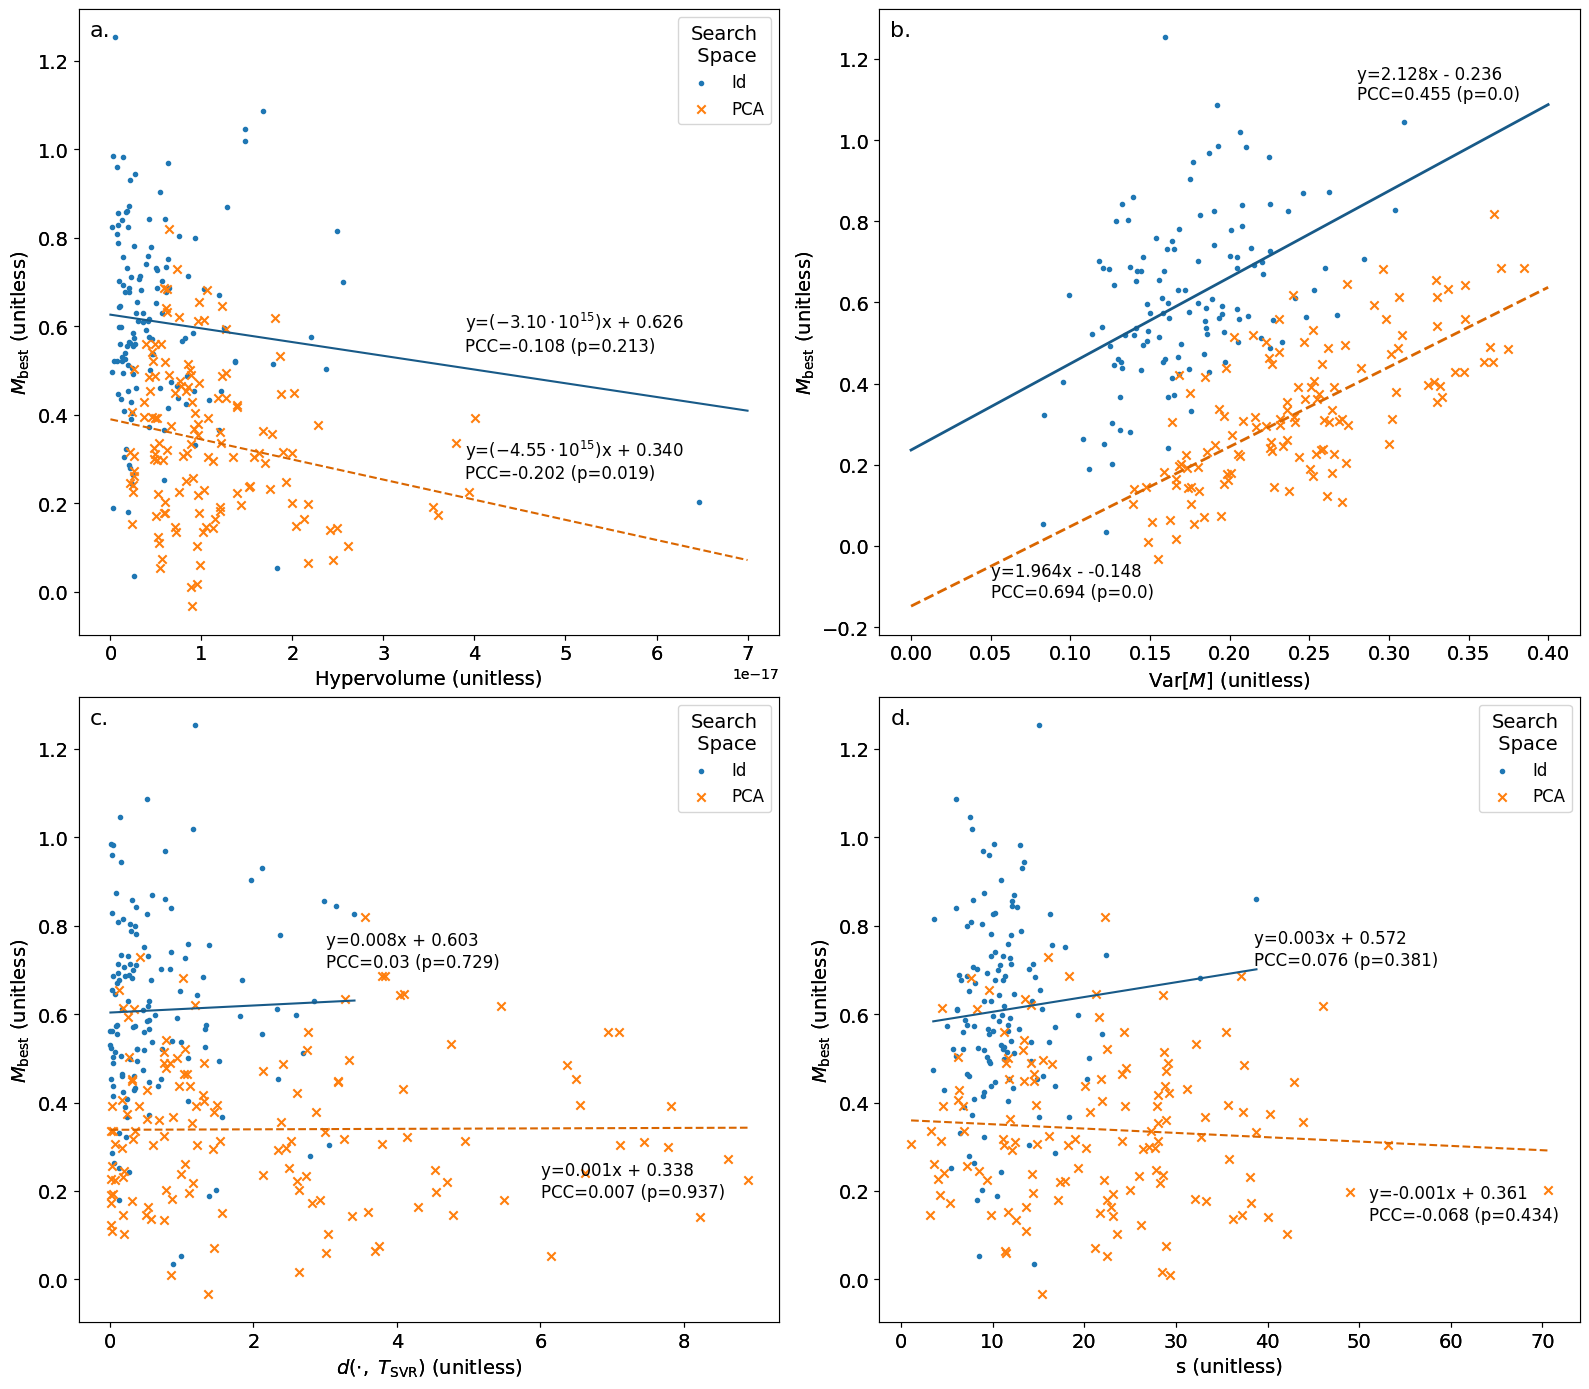

In [529]:
fig_scatterplot.tight_layout(h_pad=0.5)
fig_scatterplot

In [531]:
if SAVE_FIGURES:
    fig_scatterplot.savefig("figures/exploration_scatterplot_2x2.pdf",dpi=300)

In [532]:
# compute Pearson Correlation Coefficient
pcc_obj = pearsonr(_temp_x, _temp_y)

# fit a linear model
_reg = LinearRegression()
_reg.fit( np.array(_temp_x).reshape(-1,1), np.array(_temp_y) )
_slope = _reg.coef_[0]
_intercept = _reg.intercept_

print(pcc_obj)
print(_slope)
print(_intercept)

PearsonRResult(statistic=0.006884192414835677, pvalue=0.936838366953329)
0.0005326985
0.3383099


# Make 2x2 histograms figure

In [533]:
results_var = [results_id, results_pca]
results_hv,
results_path_length
results_set_distances

{'Id': [0.042652708,
  0.20429118,
  0.28297895,
  0.27287817,
  0.46192315,
  3.4079049,
  0.547173,
  0.36056483,
  1.0822809,
  1.1832163,
  1.4780935,
  0.6207517,
  0.38012806,
  0.23717016,
  0.70779383,
  2.348798,
  0.54047734,
  0.17095348,
  1.839568,
  0.52192247,
  0.33255216,
  0.46932733,
  0.023827052,
  0.8482449,
  0.34768048,
  0.1170655,
  0.031291902,
  2.1123276,
  0.21670152,
  1.1611717,
  0.8633246,
  0.024826065,
  0.36421168,
  0.06706163,
  1.3274153,
  0.571687,
  1.3442831,
  0.11322238,
  0.077909864,
  0.03695332,
  0.014113308,
  0.022559285,
  0.0067548184,
  0.025677163,
  0.019823464,
  0.03981596,
  0.038707927,
  0.54027283,
  0.18076676,
  1.9651141,
  1.5660535,
  0.7083763,
  0.3520469,
  0.12383447,
  1.2151192,
  0.047245007,
  0.09768464,
  0.18471989,
  1.3281937,
  0.84657836,
  0.12234973,
  0.16195643,
  0.24656716,
  1.0859008,
  0.27039596,
  0.09174551,
  0.27233878,
  0.13271904,
  0.29173493,
  0.5203611,
  0.15046822,
  2.3733957,
  

In [534]:
results_var = {}
results_var["Id"] = []
results_var["pca"] = []
for k, vdict in results_id.items():
    if "identity" in k:
        results_var["Id"] += vdict["variances"]
for k, vdict in results_pca.items():
    if "pca" in k.lower():
        results_var["pca"] += vdict["variances"]

In [535]:
results_hv_simplified = {}
results_hv_simplified["Id"] = []
results_hv_simplified["pca"] = []
for k, vdict in results_hv.items():
    if "identity" in k.lower():
        results_hv_simplified["Id"] += vdict["hypervolumes"]
for k, vdict in results_hv.items():
    if "identity" not in k.lower():
        results_hv_simplified["pca"] += vdict["hypervolumes"]

hypervolume
5.512830012086408e-18 6.272395971382492e-19
1.1016840446900131e-17 6.630479522631075e-19
1.5089648375520682e-19   1.3580683537968615e-19   2.1519651798104186e-18
[<matplotlib.patches.Rectangle object at 0x7f107f308880>, <matplotlib.patches.Rectangle object at 0x7f107f308c10>]
$\text{Var}(M)$
0.17418322075533374 0.003953992934394168
0.24487441386592806 0.005461676874947958
0.08303386862896232   0.07473048176606609   0.01005847985534361
[<matplotlib.patches.Rectangle object at 0x7f182010ec20>, <matplotlib.patches.Rectangle object at 0x7f182010efb0>]
$d(\cdot,T_{\text{SVR}})$
0.7075734734535217 0.06808172
2.305695056915283 0.1926571
0.006397543475031853   0.0057577891275286674   0.29597643818706276
[<matplotlib.patches.Rectangle object at 0x7f107ee39000>, <matplotlib.patches.Rectangle object at 0x7f107ee393c0>]
s
11.19099233629596 0.40994704164882206
21.56103661278332 1.0331671744781263
1.109641909599304   0.9986777186393736   2.316950023670991
[<matplotlib.patches.Rectangle o

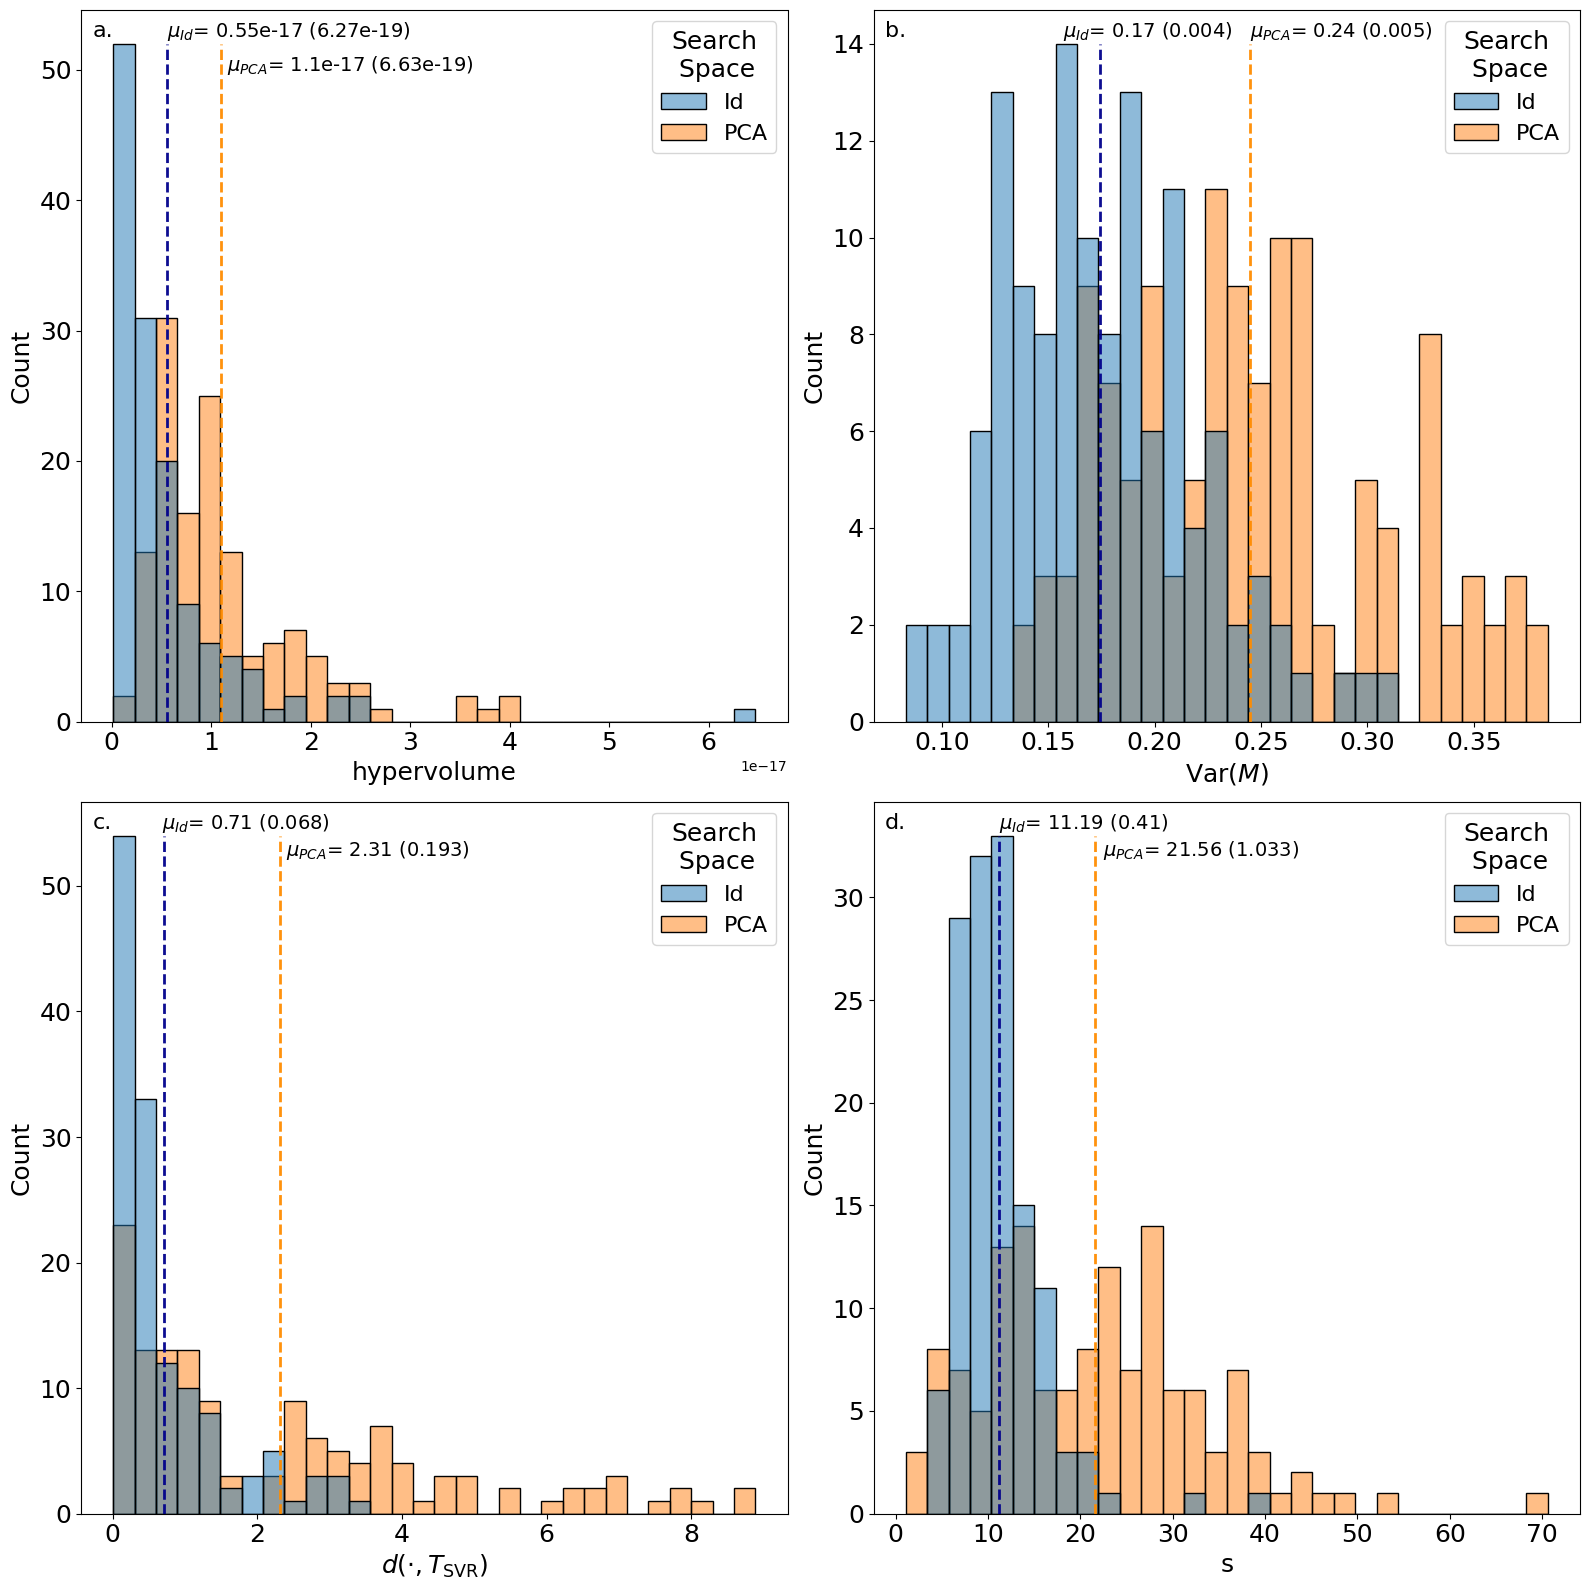

In [555]:
fig = plt.figure(figsize=(16,16))
grid= fig.add_gridspec(2,2)

names = [("$\\text{Var}(M)$",0,0, "a."), ("hypervolume",0,1,"b."), ("$d(\cdot,T_{\\text{SVR}})$",1,0, "c."), ("s",1,1, "d.")]
names = [("hypervolume",0,0,"a."), ("$\\text{Var}(M)$",0,1, "b."), ("$d(\cdot,T_{\\text{SVR}})$",1,0, "c."), ("s",1,1, "d.")]
for _tup, _results in zip(names, [results_hv_simplified, results_var, results_set_distances, results_path_length]):
    _name, _row_ix, _col_ix, _panel_label = _tup

    ax = fig.add_subplot(grid[_row_ix, _col_ix])
    ax.set_xlabel(_name,   fontsize=18)
    ax.set_ylabel("Count", fontsize=18)
    
    _temp_data = []
    _temp_data  = _results["Id"] + _results["pca"]
    _temp_labels= ["Id"]*len(_results["Id"]) + ["PCA"]*len(_results["pca"])
    
    _temp_df = pd.DataFrame(
        {
            "data":_temp_data,
            "labels":_temp_labels
        }
    )

    _means = _temp_df.groupby('labels').mean().T
    _ses  = _temp_df.groupby('labels').std().T/np.sqrt(len(_results["Id"]))
    _mean_id = float(_means.Id.iloc[0])
    _mean_pca= float(_means.PCA.iloc[0])
    _ses_id  = _ses.Id.iloc[0]
    _ses_pca = _ses.PCA.iloc[0]
    print("======")
    print(_name)
    print(_mean_id, _ses_id)
    print(_mean_pca, _ses_pca)
    print("======")
    # sns.histplot(_temp_hv_id, label="Id")
    # sns.histplot(_temp_hv_pca, label="PCA")
    ax=sns.histplot(data=_temp_df, x="data", hue="labels" ,bins=30, ax=ax)
    
    # Get the heights of the bars
    heights = [patch.get_height() for patch in ax.patches]
    bar_xvals = [patch.get_x() for patch in ax.patches]
    bar_width = ax.patches[0].get_width()
    
    # Find the max height min x
    max_height = max(heights)
    min_x = min(bar_xvals)
    print(min_x, " ", (1-0.1)*min_x, " ", bar_width)
    # ax.text(min_x-bar_width*0.85, max_height, _panel_label, fontsize=18)
    ax.annotate(
        _panel_label,  
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize=16, verticalalignment='top', fontfamily='sans-serif',
    )
    
    ax.vlines(x=_mean_id,  ymin=0, ymax=max_height, linestyle="--", color="darkblue", linewidth=2,alpha=0.95)
    ax.vlines(x=_mean_pca, ymin=0, ymax=max_height, linestyle="--", color="darkorange", linewidth=2,alpha=0.95)

    _round_amount = 2
    _text_id = "$\mu_{Id}$= " +str(round(_mean_id ,_round_amount))+" ("+str(round(_ses_id,3))+")"
    _text_pca= "$\mu_{PCA}$= "+str(round(_mean_pca,_round_amount))+" ("+str(round(_ses_pca,3))+")"
    _text_fs=14
    if "Var" in _name:
        ax.text(  x=_mean_id*(0.9),  y=max_height*(1.01), s=_text_id, fontsize=_text_fs)
        ax.text(  x=_mean_pca, y=max_height*(1.01), s=_text_pca, fontsize=_text_fs)
    elif _name=="hypervolume":
        _text_id = "$\mu_{Id}$= 0.55e-17 (6.27e-19)" # to have the exponential notation manually writing it
        _text_pca= "$\mu_{PCA}$= 1.1e-17 (6.63e-19)"
        ax.text(  x=_mean_id,  y=max_height*(1.01), s=_text_id, fontsize=_text_fs)
        ax.text(  x=_mean_pca*(1.05), y=max_height*(0.96), s=_text_pca, fontsize=_text_fs)
    elif _name=="s":
        ax.text(  x=_mean_id,  y=max_height*(1.01), s=_text_id, fontsize=_text_fs)
        ax.text(  x=_mean_pca*(1.04), y=max_height*(0.97), s=_text_pca, horizontalalignment="left", fontsize=_text_fs)
    elif "SVR" in _name:
        ax.text(  x=_mean_id*(0.96),  y=max_height*(1.01), s=_text_id, fontsize=_text_fs)
        ax.text(  x=_mean_pca*(1.04), y=max_height*(0.97), s=_text_pca, horizontalalignment="left", fontsize=_text_fs)

    
    legend = ax.get_legend()
    handles = legend.legend_handles
    ax.legend(handles=handles, labels=["Id", "PCA"], title="Search\n Space", fontsize=16, title_fontsize=18)
    print(handles)

    ax.tick_params(labelsize=18)
    
fig.tight_layout()
if SAVE_FIGURES:
        fig.savefig("figures/histogram_2x2_stratified_by_id_pca.pdf",dpi=300)

In [550]:
from scipy.stats import ttest_ind, ttest_rel

In [551]:
print(
    np.var(results_var["Id"]),
    np.var(results_var["pca"])
)

0.0019386234555296366 0.0036989093715063203


In [552]:
ttest_ind(
    results_var["Id"],
    results_var["pca"]
)

TtestResult(statistic=-10.484111047782473, pvalue=1.5843919862909633e-21, df=248.0)

In [553]:
ttest_ind(
    results_set_distances["Id"],
    results_set_distances["pca"]
)

TtestResult(statistic=-7.821171671927817, pvalue=1.2071001011250263e-13, df=268.0)

In [554]:
ttest_ind(
    results_path_length["Id"],
    results_path_length["pca"]
)

TtestResult(statistic=-9.329552648356612, pvalue=4.175817445746809e-18, df=268.0)